<a href="https://colab.research.google.com/github/SindhuDinesh2/Computer-Vision-Projects/blob/main/Malaria_detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
import json
import os

# Create the .kaggle folder
os.makedirs('/root/.kaggle/', exist_ok=True)

# Paste your Kaggle API credentials here
kaggle_api = {
    "username": "siri232",
    "key": "d124c8a7f01db0e51757993c6b3991fa"
}

# Write the kaggle.json file
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(kaggle_api, file)

# Change permissions of the file
os.chmod('/root/.kaggle/kaggle.json', 600)



In [3]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria


Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
100% 673M/675M [00:04<00:00, 170MB/s]
100% 675M/675M [00:04<00:00, 161MB/s]


In [4]:
!unzip cell-images-for-detecting-malaria.zip -d malaria_cell_images


Streaming output truncated to the last 5000 lines.
  inflating: malaria_cell_images/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: malaria_cell_images/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: malaria_cell_images/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: malaria_cell_images/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: malaria_cell_images/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: malaria_cell_images/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: malaria_cell_images/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: malaria_cell_images/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: malaria_cell_images/cell_images/

In [5]:

import numpy as np

#Set the `numpy` pseudo-random generator at a fixed value
#This helps with repeatable results everytime you run the code.
np.random.seed(1000)

import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import keras

os.environ['KERAS_BACKEND'] = 'tensorflow' # Added to set the backend as Tensorflow
#We can also set it to Theano if we want.

In [6]:
import os
import numpy as np
import cv2
from PIL import Image

# Set the correct image directory
image_directory = '/content/malaria_cell_images/cell_images/'  # Adjust based on your unzipped folder
SIZE = 64
dataset = []
label = []

# Iterate through all Parasitized images
parasitized_images = os.listdir(image_directory + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):
    if image_name.endswith('.png'):  # Only process .png files
        image = cv2.imread(image_directory + 'Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)  # Label parasitized images as 0

# Iterate through all Uninfected images
uninfected_images = os.listdir(image_directory + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    if image_name.endswith('.png'):  # Only process .png files
        image = cv2.imread(image_directory + 'Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)  # Label uninfected images as 1

# Convert dataset and label lists into numpy arrays
dataset = np.array(dataset)
label = np.array(label)

print(f"Dataset shape: {dataset.shape}")
print(f"Label shape: {label.shape}")


Dataset shape: (27558, 64, 64, 3)
Label shape: (27558,)


In [7]:
#Apply CNN
# ### Build the model

#############################################################
###2 conv and pool layers. with some normalization and drops in between.

INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)

conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3),
                               activation='relu', padding='same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1)
conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3),
                               activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)

flat = keras.layers.Flatten()(drop2)  #Flatten the matrix to get it ready for dense.

hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)
hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.2)(norm4)

out = keras.layers.Dense(2, activation='sigmoid')(drop4)   #units=1 gives error

model = keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='categorical_crossentropy',   #Check between binary_crossentropy and categorical_crossentropy
                metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248  

In [8]:
 ### Split the dataset
#
# I split the dataset into training and testing dataset.
# 1. Training data: 80%
# 2. Testing data: 20%
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20, random_state = 0)

# When training with Keras's Model.fit(), adding the tf.keras.callback.TensorBoard callback
# ensures that logs are created and stored. Additionally, enable histogram computation
#every epoch with histogram_freq=1 (this is off by default)
#Place the logs in a timestamped subdirectory to allow easy selection of different training runs.

#import datetime

#log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "/"
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [9]:
# ### Training the model
# As the training data is now ready, I will use it to train the model.

#Fit the model
history = model.fit(np.array(X_train),
                         y_train,
                         batch_size = 64,
                         verbose = 1,
                         epochs = 5,      #Changed to 3 from 50 for testing purposes.
                         validation_split = 0.1,
                         shuffle = False
                      #   callbacks=callbacks
                     )

# ## Accuracy calculation
#
# I'll now calculate the accuracy on the test data.

print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))



Epoch 1/5
311/311 [==============================] - 20s 57ms/step - loss: 0.5709 - accuracy: 0.7407 - val_loss: 1.9734 - val_accuracy: 0.6744
Epoch 2/5
311/311 [==============================] - 17s 54ms/step - loss: 0.2583 - accuracy: 0.9014 - val_loss: 0.3359 - val_accuracy: 0.8939
Epoch 3/5
311/311 [==============================] - 16s 53ms/step - loss: 0.2100 - accuracy: 0.9231 - val_loss: 0.2388 - val_accuracy: 0.9193
Epoch 4/5
311/311 [==============================] - 17s 55ms/step - loss: 0.1855 - accuracy: 0.9328 - val_loss: 0.2914 - val_accuracy: 0.8948
Epoch 5/5
173/173 [==============================] - 2s 9ms/step - loss: 0.3052 - accuracy: 0.9049
Test_Accuracy: 90.49%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


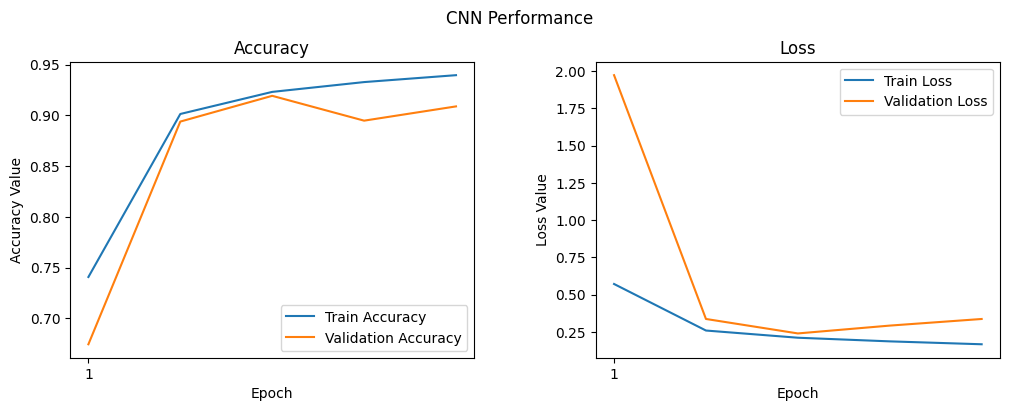

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


#Save the model
model.save('malaria_cnn.h5')


**ANOTHER WAY TO DEFINE MODEL**





In [10]:
### ANOTHER WAY TO DEFINE THE NETWORK using Sequential model
#Sequential
#You can create a Sequential model by passing a list of layer instances to the constructor:
"""
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential

model = None
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape = (SIZE, SIZE, 3), activation = 'relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Convolution2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(activation = 'relu', units=512))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Dense(activation = 'relu', units=256))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Dense(activation = 'sigmoid', units=2))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())

"""